In [1]:
!pip install transformers
!pip install sent2vec


     |████████████████████████████████| 1.8MB 9.5MB/s 
     |████████████████████████████████| 890kB 38.8MB/s 
     |████████████████████████████████| 2.9MB 50.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=72d17dfa0203229722a619f06738868d37cca7a3fc7e5bf1553d2ee76cc547b4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import warnings
from scipy import spatial
from sent2vec.vectorizer import Vectorizer


In [3]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
import json
from pathlib import Path

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                if qa['answers'] == []:
                    answers.append({'text': "", 'answer_start': -1, 'answer_end': -1})
                    contexts.append(context)
                    questions.append(question)
                else:
                    for answer in qa['answers']:
                        answers.append(answer)
                        contexts.append(context)
                        questions.append(question)

    return contexts, questions, answers

path = "/gdrive/MyDrive/ECE692:Project3Paper/"

train_contexts, train_questions, train_answers = read_squad(path + 'json/christie_training.json')
val_contexts, val_questions, val_answers = read_squad(path + 'json/christie_validation.json')
test_contexts, test_questions, test_answers = read_squad(path + 'json/christie_test.json')

# train_contexts, train_questions, train_answers = read_squad(path+'json/christi-snippets_training.json')
# val_contexts, val_questions, val_answers = read_squad(path+'json/christi-snippets_val.json')

print(len(train_contexts))
print(len(val_contexts))

47
17


In [5]:
def create_question_answers_dict(questions, answers):
  q_index = 0
  q_a_dict = {}
  question = ''
  inner_dict = {}
  ans_list = []
  for q, a in zip(questions, answers):
    if q != question:
      if (len(ans_list)>0):
        inner_dict['answers'] = ans_list
        q_a_dict[q_index] = inner_dict
        inner_dict = {}
        q_index += 1
      ans_list = []
      inner_dict['question'] = q
      question = q
      ans_list.append(a['text'])
    elif q == question:
      ans_list.append(a['text'])
      question = q

  print(q_a_dict)
  return q_a_dict
 
val_dict = create_question_answers_dict(val_questions, val_answers)


{0: {'question': "What did Daniels put on the Prime Minister's face?", 'answers': ['a pad of chloroform', 'chloroform']}, 1: {'question': 'What does Daniels direct the driver to do', 'answers': ['turn to the right']}, 2: {'question': 'What is the instantaneous anaesthetic', 'answers': ['ethylchloride', 'chloroform']}, 3: {'question': "Who is the prime minister's secretary?", 'answers': ['Captain Daniels', 'Daniels']}, 4: {'question': "What happened to the Prime Minister's face", 'answers': ['bandaged up', 'face was bandaged up']}, 5: {'question': 'Where did the police of this country hurry to', 'answers': ['across the Channel']}, 6: {'question': 'What was the illusion', 'answers': ['the abduction has taken place in France']}, 7: {'question': 'Who was Mrs. Everard', 'answers': ['Frau Bertha Ebenthal', 'aunt', 'Ebenthal', 'Frau Bertha']}, 8: {'question': 'Where did Frau Bertha Ebenthal and Daniels meet', 'answers': ['']}}


In [6]:
length = 0

for context in train_contexts:
  length = length + len(context)
avg_length_train = length/len(train_contexts)

length = 0

for context in val_contexts:
  length = length + len(context)
avg_length_val = length/len(val_contexts)

print(avg_length_train)
print(avg_length_val)

2604.8936170212764
3979.0


In [7]:
length = 0
print(len(train_answers))
print(len(val_answers))

for ans in train_answers:
  answer = ans['text']
  length = length + len(answer)
  
avg_length_train = length/len(train_answers)

length = 0

for ans in val_answers:
  answer = ans['text']
  length = length + len(answer)
avg_length_val = length/len(val_answers)

print(train_answers[:10])
print(avg_length_train)
print(avg_length_val)

47
17
[{'text': 'England', 'answer_start': 1650}, {'text': 'Peace by negotiation', 'answer_start': 568}, {'text': 'Peace', 'answer_start': 568}, {'text': 'a grey suit with a minute sponge', 'answer_start': 1796}, {'text': 'a grey suit', 'answer_start': 1796}, {'text': 'suit', 'answer_start': 1803}, {'text': 'a minute sponge', 'answer_start': 1813}, {'text': 'a minute sponge', 'answer_start': 1813}, {'text': 'a minute sponge', 'answer_start': 1813}, {'text': 'a minute sponge', 'answer_start': 1813}]
15.340425531914894
13.058823529411764


First, let’s get the character position at which the answer ends in the passage (we are given the starting position). Sometimes SQuAD answers are off by one or two characters, so we will also adjust for that.

In [8]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):

        if answer['answer_start'] == -1:
          continue

        gold_text = answer['text']
        start_idx = answer['answer_start']
        print(gold_text)
        end_idx = start_idx + len(gold_text)
        
        # sometimes squad answers are off by a character or two – fix this
        if context[start_idx:end_idx] == gold_text:
            
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
           
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
           
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters

       
add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)
print(len(val_answers))
print(len(train_answers))

England
Peace by negotiation
Peace
a grey suit with a minute sponge
a grey suit
suit
a minute sponge
a minute sponge
a minute sponge
a minute sponge
Neatness and order
Neatness and order
Neatness and order
Neatness and order
an attempted assassination of Mr. David MacAdam
an attempted assassination
attempted assassination of Mr. David MacAdam
an attempted assassination of Mr. David MacAdam
David MacAdam
David
MacAdam
Fighting Mac
in bed
sitting up in bed
bed
terror of evil-doers
terror of evil
terror
a convalescent influenza patient
influenza patient
a convalescent
a particularly noxious tisane
noxious tisane
tisane
own pet society detective
society detective
Poirot
Hercule
Second son of fifth Baron Windsor
in a woollen shawl
shawl
Our landlady
landlady
a pad of chloroform
chloroform
turn to the right
ethylchloride
chloroform
Captain Daniels
Daniels
bandaged up
face was bandaged up
across the Channel
the abduction has taken place in France
Frau Bertha Ebenthal
aunt
Ebenthal
Frau Bertha

Now train_answers and val_answers include the character end positions and the corrected start positions. Next, let’s tokenize our context/question pairs. Tokenizers can accept parallel lists of sequences and encode them together as sequence pairs.

In [9]:
from transformers import DistilBertTokenizerFast
# tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased-distilled-squad')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

# print(val_encodings)

Next we need to convert our character start/end positions to token start/end positions. When using 🤗 Fast Tokenizers, we can use the built in char_to_token() method.

In [10]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        if answers[i]['answer_start'] == -1:
            start_positions.append(tokenizer.model_max_length)
            end_positions.append(tokenizer.model_max_length)
            continue
        # print(answers[i])
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # if None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    
add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)


Our data is ready. Let’s just put it in a PyTorch/TensorFlow dataset so that we can easily use it for training. In PyTorch, we define a custom Dataset class. In TensorFlow, we pass a tuple of (inputs_dict, labels_dict) to the from_tensor_slices method.

In [11]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)


Now we can use a DistilBert model with a QA head for training:

Get pre fine-tuned accuracy on validation set

In [12]:
from transformers import DistilBertForQuestionAnswering
# model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad")

#Test on validation set
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
vectorizer = Vectorizer()

questions_count = len(val_questions)
model.to(device)
correct = 0
correct_cosine = 0
for i in range(len(val_questions)):
  context = val_contexts[i]
  question = val_questions[i]
  answer = val_answers[i]

  encoding = tokenizer.encode_plus(question, context, max_length=512)
  input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]
  start_scores, end_scores = model(torch.tensor([input_ids], device=device), 
                                   attention_mask=torch.tensor([attention_mask],
                                    device=device), return_dict=False)
  ans_tokens = input_ids[torch.argmax(start_scores.cpu()) : torch.argmax(end_scores.cpu())+1]
  answer_tokens = tokenizer.convert_ids_to_tokens(ans_tokens , skip_special_tokens=True)
  all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
  # print(val_questions[i])
  answer_tokens_to_string = tokenizer.convert_tokens_to_string(answer_tokens)
  # print('Predicted: %s Actual: %s'%(answer_tokens_to_string, answer['text']))
  if answer_tokens_to_string == '' and answer['text'] != '' or answer_tokens_to_string != '' and answer['text'] == '':
    # print('edge case..skipping')
    continue
  vectorizer.bert([answer_tokens_to_string, answer['text'].lower() ])
  vectors_bert = vectorizer.vectors
  dist_answer = spatial.distance.cosine(vectors_bert[0], vectors_bert[1])
  # print(dist_answer)
  if dist_answer < 0.03:
    # print('cosine correct')
    correct_cosine += 1
 
  if(answer_tokens_to_string.lower() in answer['text'].lower())or (answer['text'].lower() in answer_tokens_to_string.lower() ):
    # print('text correct')
    correct += 1
print('Num correct cosine: %d, correct text: %d'%(correct_cosine, correct))
print("Validation Set Accuracy: {}!".format(correct / questions_count))    
print("Validation Set Accuracy cosine: {}!".format(correct_cosine / questions_count)) 

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Num correct cosine: 5, correct text: 6
Validation Set Accuracy: 0.35294117647058826!
Validation Set Accuracy cosine: 0.29411764705882354!


The data and model are both ready to go. You can train the model with Trainer/TFTrainer exactly as in the sequence classification example above. If using native PyTorch, replace labels with start_positions and end_positions in the training example. If using Keras’s fit, we need to make a minor modification to handle this example since it involves multiple model outputs.

Option A: The steps above prepared the datasets in the way that the trainer is expected. Now all we need to do is create a model to fine-tune, define the TrainingArguments/TFTrainingArguments and instantiate a Trainer/TFTrainer.

In [13]:
from transformers import DistilBertForQuestionAnswering
# model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad")

## best results so far per device train/eval batch size = 16, epochs = 2

from transformers import Trainer, TrainingArguments

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
model.to(device)
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=1,
    learning_rate = 0.001
    
)



trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

#Test on validation set
questions_count = len(val_questions)

correct = 0
correct_cosine = 0

vectorizer = Vectorizer()
for i in range(len(val_questions)):
  context = val_contexts[i]
  question = val_questions[i]
  answer = val_answers[i]

  
  encoding = tokenizer.encode_plus(question, context, max_length=512)
  input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]
  start_scores, end_scores =  model(torch.tensor([input_ids], device=device), attention_mask=torch.tensor([attention_mask], device=device), return_dict=False)
  ans_tokens = input_ids[torch.argmax(start_scores.cpu()) : torch.argmax(end_scores.cpu())+1]
  answer_tokens = tokenizer.convert_ids_to_tokens(ans_tokens , skip_special_tokens=True)
  all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
  answer_tokens_to_string = tokenizer.convert_tokens_to_string(answer_tokens)
  print(val_questions[i])
  print('Prediction: %s Actual: %s '%(answer_tokens_to_string, answer['text']))
  if (answer_tokens_to_string == '' and answer['text'] != '') or (answer_tokens_to_string != '' and answer['text'] == ''):
    continue
  vectorizer.bert([answer_tokens_to_string.lower(), answer['text'].lower() ])
  vectors_bert = vectorizer.vectors
  dist_answer = spatial.distance.cosine(vectors_bert[0], vectors_bert[1])
  
  if dist_answer < 0.03:
    correct_cosine += 1
    print('cosine correct')
  else:
    print('cosine incorrect')  
  if(answer_tokens_to_string.lower() in answer['text'].lower()) or (answer['text'].lower() in answer_tokens_to_string.lower()):
    correct += 1
    print('text correct')
  else:
    print('text incorrect')  


print(correct)  
print("Validation Set Accuracy: {}!".format(correct / questions_count))
print(correct_cosine)     
print("Validation Set Accuracy Cosine: {}!".format(correct_cosine / questions_count))

Step,Training Loss
1,9.601900
2,9.597500
3,9.386900
4,8.843600
5,7.712600
6,7.124100


What did Daniels put on the Prime Minister's face?
Prediction: a pad of chloroform Actual: a pad of chloroform 
cosine correct
text correct
What did Daniels put on the Prime Minister's face?
Prediction: a pad of chloroform Actual: chloroform 
cosine correct
text correct
What does Daniels direct the driver to do
Prediction: o ’ murphy Actual: turn to the right 
cosine incorrect
text incorrect
What is the instantaneous anaesthetic
Prediction: ethylchloride Actual: ethylchloride 
cosine correct
text correct
What is the instantaneous anaesthetic
Prediction: ethylchloride Actual: chloroform 
cosine correct
text incorrect
Who is the prime minister's secretary?
Prediction: captain daniels Actual: Captain Daniels 
cosine correct
text correct
Who is the prime minister's secretary?
Prediction: captain daniels Actual: Daniels 
cosine correct
text correct
What happened to the Prime Minister's face
Prediction: the prime minister has never left england. he was kidnapped on his way from windsor to lo

Option B: native PyTorch 

Iteration 0 Current Loss 7.198125839233398 Batch Loss 7.198125839233398
Iteration 1 Current Loss 5.271439552307129 Batch Loss 5.271439552307129
Iteration 2 Current Loss 4.222354412078857 Batch Loss 4.222354412078857
Iteration 3 Current Loss 4.488497734069824 Batch Loss 4.488497734069824
Iteration 4 Current Loss 4.768744945526123 Batch Loss 4.768744945526123
Iteration 5 Current Loss 2.5914626121520996 Batch Loss 2.5914626121520996
Iteration 6 Current Loss 3.0594687461853027 Batch Loss 3.0594687461853027
Iteration 7 Current Loss 3.688427686691284 Batch Loss 3.688427686691284
Iteration 8 Current Loss 2.4071664810180664 Batch Loss 2.4071664810180664
Iteration 9 Current Loss 3.0741055011749268 Batch Loss 3.0741055011749268


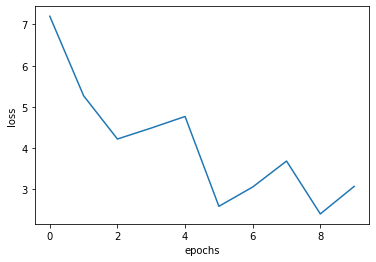

In [ ]:
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import DistilBertForQuestionAnswering


model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased-distilled-squad")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
losses = []
optim = AdamW(model.parameters(), lr=0.00001, weight_decay=0.001)

for epoch in range(10):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()
        current_loss = loss.item()
    print("Iteration {} Current Loss {} Batch Loss {}".format(epoch, current_loss, loss.item()))
    losses.append(current_loss)
model.eval()

import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

**Next Step: Is to Test on a Question**

In [ ]:
#Test using a question from the test dataset
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
questions_count = len(train_questions)

correct = 0

for i in range(questions_count):
  context = train_contexts[i]
  question = train_questions[i]
  answer = train_answers[i]

  #print(answer['text'].lower())

  encoding = tokenizer.encode_plus(question, context, max_length=512)

  input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]

  start_scores, end_scores = model(torch.tensor([input_ids], device=device), attention_mask=torch.tensor([attention_mask], device=device), return_dict=False)

  ans_tokens = input_ids[torch.argmax(start_scores) : torch.argmax(end_scores)+1]
  answer_tokens = tokenizer.convert_ids_to_tokens(ans_tokens , skip_special_tokens=True)

  all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
  answer_tokens_to_string = tokenizer.convert_tokens_to_string(answer_tokens)

  if(answer_tokens_to_string in answer['text'].lower()):
    correct += 1
  print("Training Set Accuracy: {}!".format(correct / questions_count))
  print("Question: {}\nAnswer {}".format(question, answer_tokens_to_string))


Token indices sequence length is longer than the specified maximum sequence length for this model (738 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: ignored

In [ ]:
#Test on validation set
questions_count = len(val_questions)

correct = 0
correct_cosine = 0

vectorizer = Vectorizer()
for i in range(len(val_questions)):
  context = val_contexts[i]
  question = val_questions[i]
  answer = val_answers[i]

  # print(context)
  # print(question)
  # print(answer)
  encoding = tokenizer.encode_plus(question, context, max_length=512)
  input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]
  start_scores, end_scores = model(torch.tensor([input_ids], device=device), attention_mask=torch.tensor([attention_mask], device=device), return_dict=False)
  ans_tokens = input_ids[torch.argmax(start_scores.cpu()) : torch.argmax(end_scores.cpu())+1]
  answer_tokens = tokenizer.convert_ids_to_tokens(ans_tokens , skip_special_tokens=True)
  all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
  answer_tokens_to_string = tokenizer.convert_tokens_to_string(answer_tokens)
  print('Predicted: %s Actual %s'%(answer_tokens_to_string, answer['text']))
  if (answer_tokens_to_string == '' and answer['text'] != '') or (answer_tokens_to_string != '' and answer['text'] == ''):
    continue
  vectorizer.bert([answer_tokens_to_string.lower(), answer['text'].lower() ])
  vectors_bert = vectorizer.vectors
  dist_answer = spatial.distance.cosine(vectors_bert[0], vectors_bert[1])
  
  if dist_answer < 0.03:
    print('cosine correct')
    correct_cosine += 1
  else:
    print('cosine incorrect')  
  if(answer_tokens_to_string.lower() in answer['text'].lower()) or (answer['text'].lower() in answer_tokens_to_string.lower()):
    print('text correct')
    correct += 1
  else:
    print('text incorrect')   
  

print(correct)  
print("Validation Set Accuracy: {}!".format(correct / questions_count))
print(correct_cosine)     
print("Validation Set Accuracy Cosine: {}!".format(correct_cosine / questions_count))

RuntimeError: ignored

In [ ]:

sentences = [
    "house of ‘ mrs. everard",
    "Mrs. Everard,'",
    "hampstead",
    "a pad of chloroform",
    "chloroform",
]



vectorizer.bert(sentences)
vectors_bert = vectorizer.vectors

dist_1 = spatial.distance.cosine(vectors_bert[0], vectors_bert[1])
dist_2 = spatial.distance.cosine(vectors_bert[3], vectors_bert[4])
#dist_3 = spatial.distance.cosine(vectors_bert[2], vectors_bert[1])
print('dist_1: {0}, '.format(dist_1))
print('dist_2: {0}, '.format(dist_2))
#print('dist_3: {0}, '.format(dist_3))
# dist_1: 0.043, dist_2: 0.192

dist_1: 0.0329669713973999, 
dist_2: 0.02843719720840454, 


In [14]:
##install BLEU score
!pip install bleu
!pip install --upgrade nltk

  Created wheel for bleu: filename=bleu-0.3-cp36-none-any.whl size=5801 sha256=4274fd65beaa22f67907604731b17c6deb9dfc098156cb049e6f20e4f8b44c7f
  Stored in directory: /root/.cache/pip/wheels/a9/95/e7/cb43a1c509c38fedbee6223963e34a51a94d8991f3b3e1888e
  Created wheel for efficiency: filename=efficiency-0.4-cp36-none-any.whl size=19616 sha256=4050ee6f3157e374cca247554c8b7574c2e76b7ed1d4e650c8d6f3129c728aa8
  Stored in directory: /root/.cache/pip/wheels/1c/67/60/11693f94754d75dabfadb120c7ba380e7ef2aed8d3dccd00bf
Successfully built bleu efficiency
     |████████████████████████████████| 1.4MB 8.4MB/s 
  Created wheel for nltk: filename=nltk-3.5-cp36-none-any.whl size=1434678 sha256=9cecf1a7cfcc77c7aa94e95f4505d25fee1dc549682227e9464684bbd9c19092
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [15]:
from bleu import list_bleu,multi_list_bleu ##import bleu metric
from nltk.translate import meteor_score ## import meteor metric
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
##Use of bleu with example answers
answers = [["answer of question 1"],["answer of question 1"]]
prediction = [['answer of question 1'],['answer of question 1']]
bleu_score = multi_list_bleu(answers,prediction)
print(bleu_score)

##when there are multiple right answers for one question
answers = [["answer of question 1"],["alternative answer of Q1"]]##each right answer is in a list
prediction = ['alternative answer of Q1']
bleu_score = list_bleu(answers,prediction)
print(bleu_score)

[100.0, 100.0]
100.0


In [ ]:
##Use of meteor with example answers
##when there are multiple right answers for one question
answers = ["answer of question 1","alternative answer of Q1"]##all right answers in one list
prediction = 'alternative answer of Q1' ## a string not a list
meteor_scores = meteor_score.meteor_score(answers,prediction)
print(meteor_scores)

0.9921875


In [29]:
import numpy as np
#Test on validation set
questions_count = len(val_questions)

bleu_scores = []
meteor_scores = []

vectorizer = Vectorizer()
for i in range(len(val_questions)):
  context = val_contexts[i]
  question = val_questions[i]
  answer = val_answers[i]
  
  encoding = tokenizer.encode_plus(question, context, max_length=512)
  input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]
  start_scores, end_scores =  model(torch.tensor([input_ids], device=device), attention_mask=torch.tensor([attention_mask], device=device), return_dict=False)
  ans_tokens = input_ids[torch.argmax(start_scores.cpu()) : torch.argmax(end_scores.cpu())+1]
  answer_tokens = tokenizer.convert_ids_to_tokens(ans_tokens , skip_special_tokens=True)
  all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
  answer_tokens_to_string = tokenizer.convert_tokens_to_string(answer_tokens)
  
  bleu_scores.append(list_bleu([answer['text']],[answer_tokens_to_string]))
  meteor_scores.append(meteor_score.meteor_score([answer['text']],answer_tokens_to_string))

print(np.mean(bleu_scores))
print(bleu_scores)
print(np.mean(meteor_scores))
print(meteor_scores)

0.22058823529411764
[5.75, 0.0, -1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.19772556771613625
[0.5291666666666667, 0.3846153846153847, 0.0, 0.5, 0.0, 0.9375, 0.45454545454545453, 0.06208609271523179, 0.4934210526315789, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
